In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, Input
print(f'Tensorflow version: {tf.__version__}')

Tensorflow version: 2.5.0


In [2]:
df = pd.read_csv("train_test_split.csv")
df.head()

,Unnamed: 0,test_cat,test_dog,train_cat,train_dog
0,0,cat_22.wav,dog_barking_97.wav,cat_99.wav,dog_barking_33.wav
1,1,cat_116.wav,dog_barking_0.wav,cat_54.wav,dog_barking_86.wav
2,2,cat_155.wav,dog_barking_93.wav,cat_34.wav,dog_barking_45.wav
3,3,cat_58.wav,dog_barking_10.wav,cat_132.wav,dog_barking_76.wav
4,4,cat_77.wav,dog_barking_26.wav,cat_124.wav,dog_barking_4.wav


In [3]:
dog_train_path = "./train/dog/"
dog_test_path = "./test/dogs/"

cat_train_path = "./train/cat/"
cat_test_path = "./test/cats/"

train_cat_fnames=os.listdir(cat_train_path)
train_cat_fnames[:10]

['cat_123.wav',
 'cat_68.wav',
 'cat_134.wav',
 'cat_165.wav',
 'cat_157.wav',
 'cat_45.wav',
 'cat_9.wav',
 'cat_94.wav',
 'cat_23.wav',
 'cat_150.wav']

In [4]:
test_cat = df[['test_cat']].dropna().rename(index=str, columns={"test_cat": "file"}).assign(label=0)
test_dog = df[['test_dog']].dropna().rename(index=str, columns={"test_dog": "file"}).assign(label=1)
train_cat = df[['train_cat']].dropna().rename(index=str, columns={"train_cat": "file"}).assign(label=0)
train_dog = df[['train_dog']].dropna().rename(index=str, columns={"train_dog": "file"}).assign(label=1)

test_df = pd.concat([test_cat, test_dog]).reset_index(drop=True)
train_df = pd.concat([train_cat, train_dog]).reset_index(drop=True)

train_df.head(300)

,file,label
0,cat_99.wav,0
1,cat_54.wav,0
2,cat_34.wav,0
3,cat_132.wav,0
4,cat_124.wav,0
...,...,...
174,dog_barking_9.wav,1
175,dog_barking_111.wav,1
176,dog_barking_67.wav,1
177,dog_barking_108.wav,1


In [5]:
path=os.path.join(cat_train_path, df['train_cat'].loc[0])

In [6]:
from pydub import AudioSegment

wav_file = AudioSegment.from_file(file=path, format="wav") 

print(f"Data type: {type(wav_file)}") 
print(f"Frame rate: {wav_file.frame_rate/1000} kHz")
print(f"Channels: {wav_file.channels}") 
print(f"Number of bytes per sample: {wav_file.sample_width*8} bit") 
print(f"Maximum amplitude: {wav_file.max}")
print(f"Length: {len(wav_file) / 1000.0} s")
print(f"Loudness dBFS: {wav_file.dBFS:.2f} dB")
print(f"Loudness max_dBFS: {wav_file.max_dBFS:.2f} dB")
print(f"Loudness RMS{wav_file.rms}")

samples = wav_file.get_array_of_samples()
samples = np.array(samples)
print(samples)

Data type: <class 'pydub.audio_segment.AudioSegment'>
Frame rate: 16.0 kHz
Channels: 1
Number of bytes per sample: 16 bit
Maximum amplitude: 24983
Length: 12.0 s
Loudness dBFS: -23.01 dB
Loudness max_dBFS: -2.36 dB
Loudness RMS2317
[-2424 -1681  -176 ... -6328 -4373 -3633]


16000
[-2424 -1681  -176 ... -6328 -4373 -3633]
int16
[-0.07397235 -0.05129848 -0.00537093 ... -0.19310934 -0.1334493
 -0.11086698]


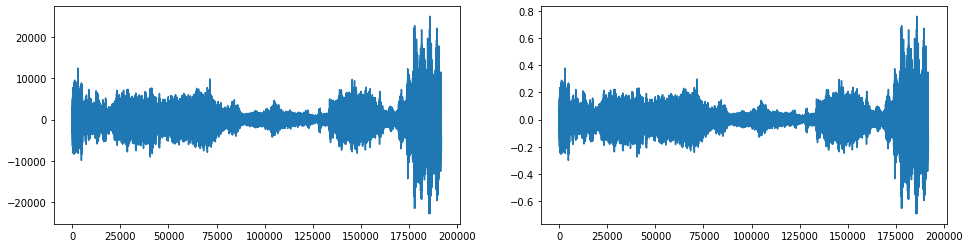

In [7]:
from scipy.io import wavfile

samplerate, data_arr = wavfile.read(path)
print(samplerate)
print(data_arr)

print(data_arr.dtype)
if data_arr.dtype == 'int16':
    nb_bits = 16  # -> 16-bit wav files
elif data_arr.dtype == 'int32':
    nb_bits = 32  # -> 32-bit wav files
    
max_nb_bit = float(2 ** (nb_bits - 1))
samples = data_arr / (max_nb_bit + 1)
print(samples)

fig, axs = plt.subplots(1, 2, figsize=(16,4))
axs[0].plot(data_arr)
axs[1].plot(samples);

[-0.07397461 -0.05130005 -0.00537109 ... -0.19311523 -0.13345337
 -0.11087036]
16000


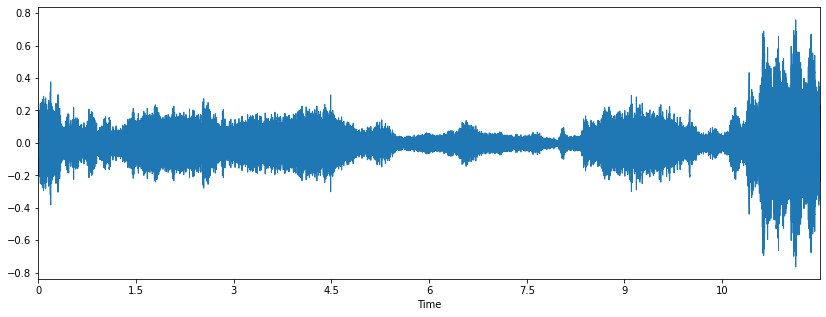

In [8]:
import librosa
import librosa.display

y, sr = librosa.load(path, sr=None)
print(y)
print(sr)
plt.figure(figsize=(14, 5))
librosa.display.waveplot(y, sr=sr);

In [9]:
train_dir='./train'
test_dir='./test'

file_train = tf.io.gfile.glob(train_dir + '/*/*')
file_train = tf.random.shuffle(file_train)
train_ds=file_train[:168]
val_ds = file_train[168:168+42]

file_test = tf.io.gfile.glob(test_dir + '/*/*')
file_test = tf.random.shuffle(file_test)
test_ds=file_test

print(train_ds.shape)
print(val_ds.shape)
print(test_ds.shape)

(168,)
(42,)
(67,)


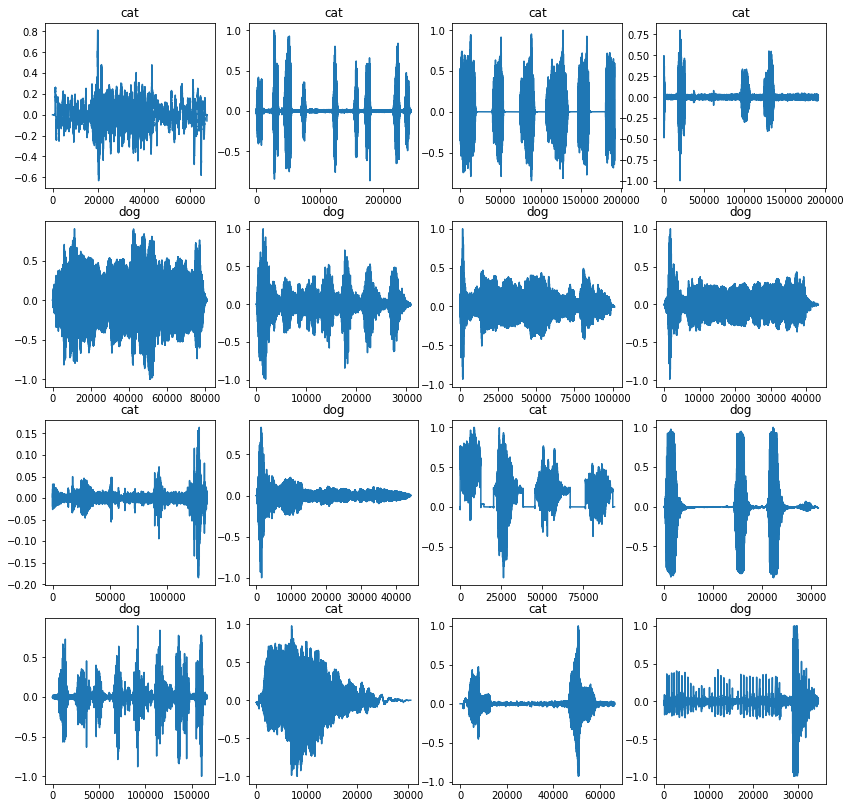

In [16]:
def get_waveform_label(file):
    lab = tf.strings.split(file, os.path.sep)[-2]
    audio_binary = tf.io.read_file(file)
    audio, _ = tf.audio.decode_wav(audio_binary)
    waveform=tf.squeeze(audio, axis=-1)
    return waveform, lab

AUTO = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_ds)
waveform_ds = files_ds.map(get_waveform_label, num_parallel_calls=AUTO)
fig, axs = plt.subplots(4,4,figsize=(14,14))

for i, (audio,label) in enumerate(waveform_ds.take(4*4)):
    r = i//4
    c = i%4
    ax = axs[r][c]
    ax.plot(audio.numpy())
    label = label.numpy().decode('utf-8')
    ax.set_title(label)

<ipython-input-17-96a37fef704c>:12: RuntimeWarning: divide by zero encountered in log
  log_spec = np.log(spectrogram.T)


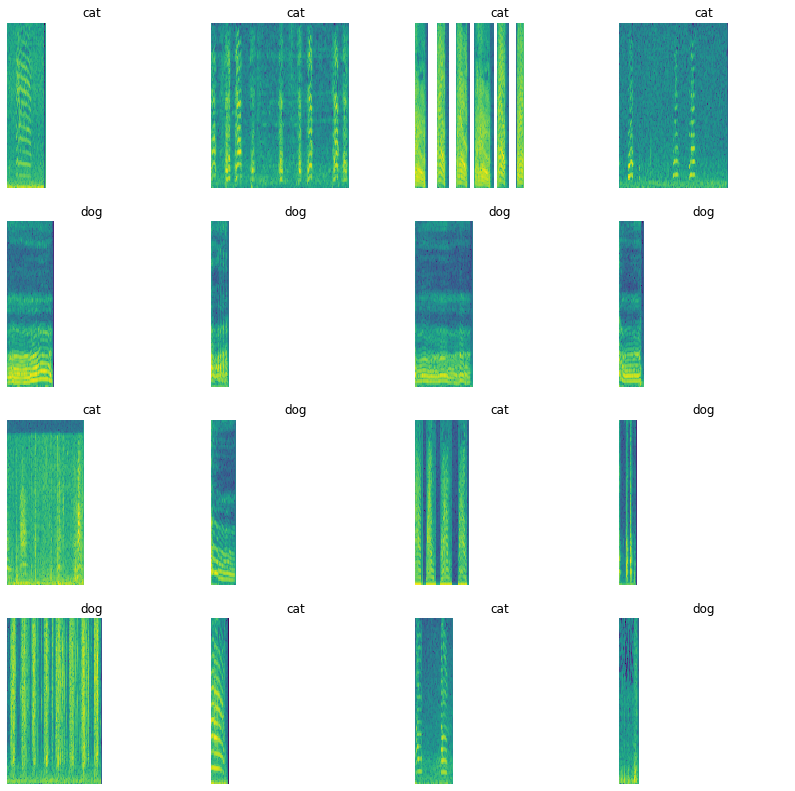

In [17]:
def get_spectrogram_label(audio, label):
    padding = tf.zeros([300000]-tf.shape(audio), dtype=tf.float32)
    wave = tf.cast(audio, tf.float32)
    eq_length = tf.concat([wave, padding], 0)
    spectrogram = tf.signal.stft(eq_length, frame_length=210, frame_step=110)    
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, -1)
    label_id = tf.argmax(label == labels)
    return spectrogram, label_id

def plot_spect(spectrogram, ax):
    log_spec = np.log(spectrogram.T)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

Name=["cat", "dog", "test"]
labels = np.array(Name)
spectrogram_ds = waveform_ds.map(get_spectrogram_label, num_parallel_calls=AUTO)
fig, axes = plt.subplots(4,4, figsize=(14,14))

for i, (spectrogram,label_id) in enumerate(spectrogram_ds.take(4*4)):
    r = i//4
    c = i%4
    ax = axes[r][c]
    plot_spect(np.squeeze(spectrogram.numpy()), ax)
    ax.set_title(labels[label_id.numpy()])
    ax.axis('off')

In [18]:
def preprocess(file):
    files_ds = tf.data.Dataset.from_tensor_slices(file)
    output_ds = files_ds.map(get_waveform_label,num_parallel_calls=AUTO)
    output_ds = output_ds.map(get_spectrogram_label,num_parallel_calls=AUTO)
    return output_ds

train_ds = spectrogram_ds
val_ds = preprocess(val_ds)
test_ds = preprocess(test_ds)

batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

train_ds = train_ds.cache().prefetch(AUTO)
val_ds = val_ds.cache().prefetch(AUTO)
for spectrogram,_ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape

num_labels = len(labels)
norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

print(input_shape)
print(num_labels)

(2726, 129, 1)
3


In [19]:
model = Sequential([
   Input(shape=input_shape), preprocessing.Resizing(32, 32), norm_layer,
   Conv2D(32,3, activation='relu'),
   Conv2D(64,3, activation='relu'),
   MaxPool2D(),
   Dropout(0.5),
   Conv2D(128,7, activation='relu'),
   Conv2D(256,7, activation='relu'),
   MaxPool2D(),
   Dropout(0.5),
   Flatten(),
   Dense(128, activation='relu'),
   Dropout(0.2),
   Dense(16, activation='relu'),
   Dense(num_labels),
])

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         4

In [20]:
his = model.fit(train_ds, epochs=100, validation_data=val_ds)

Epoch 1/100
3/3 [==============================] - 31s 7s/step - loss: 3.0178 - accuracy: 0.2143 - val_loss: 2.4053 - val_accuracy: 0.5714
Epoch 2/100
3/3 [==============================] - 7s 2s/step - loss: 2.7635 - accuracy: 0.3274 - val_loss: 0.8305 - val_accuracy: 0.5714
Epoch 3/100
3/3 [==============================] - 7s 2s/step - loss: 1.0310 - accuracy: 0.4583 - val_loss: 0.9763 - val_accuracy: 0.4762
Epoch 4/100
3/3 [==============================] - 6s 2s/step - loss: 0.9087 - accuracy: 0.5060 - val_loss: 0.7430 - val_accuracy: 0.4048
Epoch 5/100
3/3 [==============================] - 6s 2s/step - loss: 0.6938 - accuracy: 0.5000 - val_loss: 0.6210 - val_accuracy: 0.5714
Epoch 6/100
3/3 [==============================] - 6s 2s/step - loss: 0.6677 - accuracy: 0.3929 - val_loss: 0.6559 - val_accuracy: 0.5714
Epoch 7/100
3/3 [==============================] - 5s 2s/step - loss: 0.5887 - accuracy: 0.4821 - val_loss: 0.7116 - val_accuracy: 0.5714
Epoch 8/100
3/3 [================

Epoch 60/100
3/3 [==============================] - 5s 2s/step - loss: 0.2427 - accuracy: 0.4405 - val_loss: 2.2216 - val_accuracy: 0.5714
Epoch 61/100
3/3 [==============================] - 4s 1s/step - loss: 0.1860 - accuracy: 0.6012 - val_loss: 2.2890 - val_accuracy: 0.5714
Epoch 62/100
3/3 [==============================] - 4s 1s/step - loss: 0.1862 - accuracy: 0.5714 - val_loss: 2.1808 - val_accuracy: 0.5714
Epoch 63/100
3/3 [==============================] - 3s 1000ms/step - loss: 0.1937 - accuracy: 0.5893 - val_loss: 2.0672 - val_accuracy: 0.5952
Epoch 64/100
3/3 [==============================] - 3s 1s/step - loss: 0.1892 - accuracy: 0.5536 - val_loss: 2.1759 - val_accuracy: 0.5476
Epoch 65/100
3/3 [==============================] - 3s 1s/step - loss: 0.1696 - accuracy: 0.5000 - val_loss: 2.2716 - val_accuracy: 0.6190
Epoch 66/100
3/3 [==============================] - 3s 1s/step - loss: 0.2866 - accuracy: 0.6012 - val_loss: 2.3099 - val_accuracy: 0.7143
Epoch 67/100
3/3 [=====

In [22]:
his2 = model.fit(train_ds, epochs=30, validation_data=val_ds)

Epoch 1/30
3/3 [==============================] - 2s 699ms/step - loss: 0.2522 - accuracy: 0.5119 - val_loss: 1.7283 - val_accuracy: 0.4762
Epoch 2/30
3/3 [==============================] - 2s 773ms/step - loss: 0.2523 - accuracy: 0.4762 - val_loss: 1.6146 - val_accuracy: 0.5000
Epoch 3/30
3/3 [==============================] - 4s 2s/step - loss: 0.2126 - accuracy: 0.4464 - val_loss: 1.9756 - val_accuracy: 0.4762
Epoch 4/30
3/3 [==============================] - 4s 1s/step - loss: 0.1459 - accuracy: 0.4702 - val_loss: 2.2829 - val_accuracy: 0.4762
Epoch 5/30
3/3 [==============================] - 5s 2s/step - loss: 0.1618 - accuracy: 0.4702 - val_loss: 2.0678 - val_accuracy: 0.4762
Epoch 6/30
3/3 [==============================] - 5s 2s/step - loss: 0.1984 - accuracy: 0.4524 - val_loss: 1.9496 - val_accuracy: 0.4762
Epoch 7/30
3/3 [==============================] - 5s 1s/step - loss: 0.1527 - accuracy: 0.4107 - val_loss: 1.9510 - val_accuracy: 0.4762
Epoch 8/30
3/3 [===================

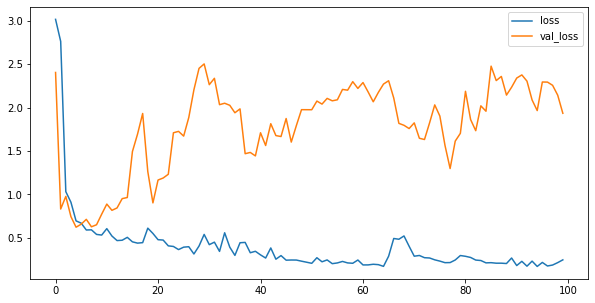

In [21]:
fig, ax = plt.subplots(figsize=(10,5))

plt.plot(his.epoch, his.history['loss'], his.history['val_loss'])
plt.legend(['loss', 'val_loss']);

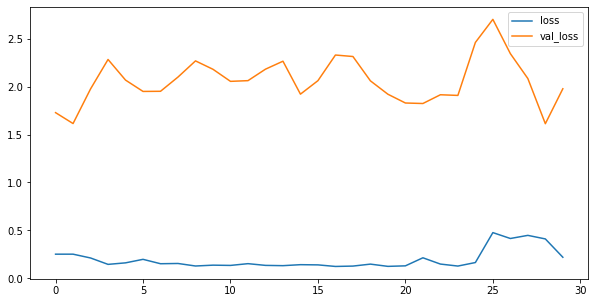

In [23]:
fig, ax = plt.subplots(figsize=(10,5))

plt.plot(his2.epoch, his2.history['loss'], his2.history['val_loss'])
plt.legend(['loss', 'val_loss']);

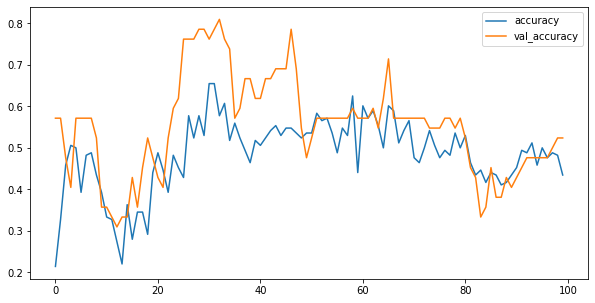

In [24]:
fig, ax = plt.subplots(figsize=(10,5))

plt.plot(his.epoch, his.history['accuracy'], his.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy']);

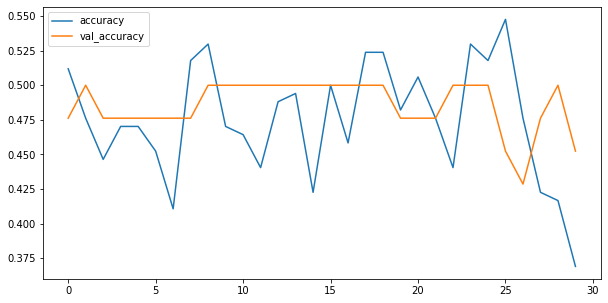

In [25]:
fig, ax = plt.subplots(figsize=(10,5))

plt.plot(his2.epoch, his2.history['accuracy'], his2.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy']);

In [26]:
test_audio = []
test_labels = []

for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)
y_pred = np.argmax(model.predict(test_audio), axis=1)
print(y_pred)

t_labels=[]
pred_labels=[]

for item in test_labels:
    if item == 2:
        t_labels+=[1]
    else:
        t_labels+=[0]
        
for item in y_pred:
    if item == 2:
        pred_labels+=[1]
    else:
        pred_labels+=[item]

y_true = np.array(t_labels)

y_pred = np.array(pred_labels)
print(y_pred)

[1 0 0 0 2 0 2 0 1 2 2 0 1 2 0 1 0 0 2 2 0 0 0 0 0 0 0 2 0 2 0 2 0 0 2 0 1
 1 2 2 2 0 2 1 1 2 0 2 2 0 2 0 0 0 0 2 0 0 0 0 0 2 2 0 0 0 0]
[1 0 0 0 1 0 1 0 1 1 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1 0 1
 1 1 1 1 0 1 1 1 1 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0]


In [27]:
test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 55%


In [28]:
from sklearn.metrics import classification_report, log_loss, accuracy_score

print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.55      0.71        67
           1       0.00      0.00      0.00         0

    accuracy                           0.55        67
   macro avg       0.50      0.28      0.36        67
weighted avg       1.00      0.55      0.71        67



/home/arivle/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 33.0, 'Predicted label')

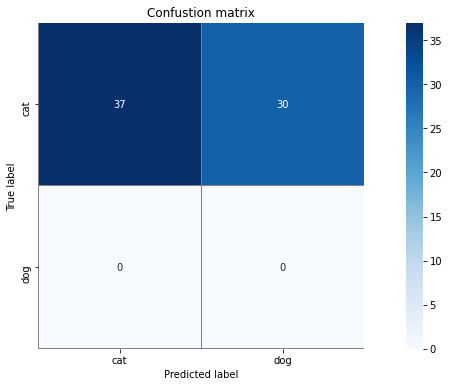

In [29]:
cm = tf.math.confusion_matrix(y_true, y_pred)

f, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(cm, xticklabels=Name[:2], yticklabels=Name[:2], annot=True, cmap='Blues', square=True, linewidths=0.01, linecolor='grey')
plt.title('Confustion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

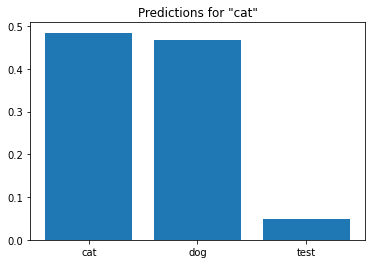

In [30]:
sample_file = './test/cats/cat_129.wav'

sample_ds = preprocess([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
    prediction = model(spectrogram)
    plt.bar(Name, tf.nn.softmax(prediction[0]))
    plt.title(f'Predictions for "{Name[label[0]]}"')